
# Steel Energy — EDA en POO 

v2 con **Programación Orientada a Objetos**, dividido por secciones:
- Carga y exploración
- Limpieza y corrección
- EDA univariado
- EDA específico por columna
- EDA multivariado
- Pipeline orquestador y ejecución


## 1) Imports y constantes

In [1]:

from __future__ import annotations
from dataclasses import dataclass
from typing import Iterable, Optional, Dict, Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Variable objetivo
TARGET_COL = "usage_kwh"


## 2) Base de utilidades (POO)

In [2]:

class BaseUtils:
    @staticmethod
    def _norm(s: str) -> str:
        return str(s).lower().replace(" ", "").replace("_", "").replace(".", "")

    def _resolve_column_name(self, df: pd.DataFrame, candidates: Iterable[str]) -> str:
        mapping = {self._norm(c): c for c in df.columns}
        for cand in candidates:
            key = self._norm(cand)
            if key in mapping:
                return mapping[key]
        raise KeyError(f"No se encontró ninguna de {list(candidates)} en columnas: {list(df.columns)}")


## 3) Carga y exploración

In [3]:

@dataclass
class DataLoader(BaseUtils):
    path: str
    def load(self) -> pd.DataFrame:
        df = pd.read_csv(self.path)
        print(f"✅ Cargado: {self.path} | shape={df.shape}")
        return df

class DataExplorer(BaseUtils):
    def __init__(self, df: pd.DataFrame):
        self.df = df
    def head_t(self, n: int = 5):
        print(self.df.head(n).T)
    def describe(self, include="all"):
        print(self.df.describe(include=include))
    def info(self):
        print(self.df.info())


## 4) Limpieza y corrección de formatos

In [4]:

@dataclass
class DataCleaner(BaseUtils):
    df: pd.DataFrame
    numeric_cols: Optional[List[str]] = None
    text_cols: Optional[List[str]] = None
    date_col: str = "date"

    def __post_init__(self):
        if self.numeric_cols is None:
            self.numeric_cols = [
                "usage_kwh",
                "lagging_current_reactive.power_kvarh",
                "leading_current_reactive_power_kvarh",
                "co2(tco2)",
                "lagging_current_power_factor",
                "leading_current_power_factor",
                "nsm",
            ]
        if self.text_cols is None:
            self.text_cols = ["weekstatus", "day_of_week", "load_type"]

    def run(self, index_to_check: int = 32905) -> Tuple[pd.DataFrame, pd.DataFrame]:
        df = self.df.copy()

        # Normaliza encabezados
        df.columns = (
            df.columns.astype(str)
            .str.strip()
            .str.lower()
            .str.replace(" ", "_")
        )

        # Duplicados
        df = df.drop_duplicates().reset_index(drop=True)

        # Fecha
        if self.date_col in df.columns:
            df[self.date_col] = pd.to_datetime(df[self.date_col], errors="coerce")

        # Numéricas
        for col in self.numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        # Texto
        for col in self.text_cols:
            if col in df.columns:
                df[col] = (
                    df[col].astype(str)
                    .str.strip()
                    .str.replace(r"\s+", " ", regex=True)
                    .str.lower()
                    .replace({"nan": np.nan, "none": np.nan, "na": np.nan, "": np.nan})
                )
                df.loc[df[col].notna(), col] = df.loc[df[col].notna(), col].str.capitalize()

        # NaNs + verificaciones
        print("\nConteo de NaN por columna:")
        print(df.isna().sum())

        print("\nMuestra aleatoria (20 filas):")
        print(df.sample(min(20, len(df))))

        print("\nInfo del DataFrame:")
        df.info()

        print(f"\n# Fila con índice == {index_to_check}")
        row_check = df[df.index == index_to_check]
        print(row_check)

        return df, row_check


## 5) EDA univariado (boxplots, percentiles, cap)

In [5]:

@dataclass
class UnivariateAnalyzer(BaseUtils):
    df: pd.DataFrame

    def describe_with_percentiles(
        self, column: str, percentiles: Iterable[float] = (0.05, 0.25, 0.5, 0.75, 0.99)
    ) -> pd.Series:
        col = self._resolve_column_name(self.df, [column])
        desc = self.df[col].describe(percentiles=list(percentiles))
        print(desc)
        return desc

    def plot_box_with_percentile(
        self, column: str, percentile: float = 0.99, title_prefix: str = "Distribución", log_y: bool = False
    ) -> float:
        col = self._resolve_column_name(self.df, [column])
        pval = float(self.df[col].quantile(percentile))
        plt.figure(figsize=(6, 4))
        plt.boxplot(self.df[col].dropna(), vert=True, patch_artist=True)
        if log_y:
            plt.yscale("log")
        plt.axhline(y=pval, color="red", linestyle="--", label=f"p{int(percentile*100)}={pval:.3g}")
        plt.title(f"{title_prefix} de {col}")
        plt.ylabel(col + (" (log)" if log_y else ""))
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.legend()
        plt.show()
        return pval

    def analyze_and_cap(
        self, column: str, cap_value: Optional[float] = None, percentile: float = 0.99
    ) -> Tuple[pd.DataFrame, float]:
        self.describe_with_percentiles(column)
        pval = self.plot_box_with_percentile(column, percentile)
        cut = pval if cap_value is None else float(cap_value)
        col = self._resolve_column_name(self.df, [column])
        df_f = self.df[self.df[col] <= cut].copy()
        print(f"\nDescribe (<= {cut:.6g})")
        print(df_f[col].describe())
        return df_f, pval


## 6) EDA específico por columna

In [6]:

@dataclass
class SpecificAnalyzer(BaseUtils):
    df: pd.DataFrame

    def analyze_lagging_reactive_kvarh(self) -> None:
        col = self._resolve_column_name(
            self.df, ["Lagging_Current_Reactive.Power_kVarh", "lagging_current_reactive.power_kvarh"]
        )
        UnivariateAnalyzer(self.df).describe_with_percentiles(col)
        UnivariateAnalyzer(self.df).plot_box_with_percentile(col, 0.99)

    def analyze_co2_tco2(self, hard_cap: float = 0.070) -> pd.DataFrame:
        col = self._resolve_column_name(self.df, ["co2(tco2)"])
        UnivariateAnalyzer(self.df).describe_with_percentiles(
            col, percentiles=(0.05, 0.25, 0.5, 0.75, 0.96, 0.99, 0.995)
        )
        UnivariateAnalyzer(self.df).plot_box_with_percentile(col, 0.99)
        df_cap = self.df[self.df[col] <= hard_cap].copy()
        print(f"\nFiltrado: {col} <= {hard_cap}")
        df_cap.info()
        UnivariateAnalyzer(df_cap).plot_box_with_percentile(col, 0.99, title_prefix="Distribución (filtrado)")
        return df_cap


## 7) EDA multivariado (matriz de correlación)

In [7]:

@dataclass
class MultivariateAnalyzer(BaseUtils):
    df: pd.DataFrame

    def plot_correlation_matrix(
        self, include_dtypes: Iterable[str] = ("float64", "int64"), title: str = "Matriz de Correlación"
    ) -> None:
        num_df = self.df.select_dtypes(include=list(include_dtypes))
        plt.figure(figsize=(12, 8))
        sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
        plt.title(title)
        plt.show()


## 8) Pipeline orquestador (flujo idéntico al original)

In [8]:

@dataclass
class SteelEnergyPipeline(BaseUtils):
    target_col: str = TARGET_COL

    def run_for_paths(self, path_modificado: str, path_objetivo: Optional[str] = None) -> Dict[str, pd.DataFrame]:
        # 1) Carga
        df_mod = DataLoader(path_modificado).load()
        df_obj = DataLoader(path_objetivo).load() if path_objetivo else None

        # 2) Limpieza
        df_clean, row_32905 = DataCleaner(df_mod).run(index_to_check=32905)

        # 3) Univariado target + cap=157
        uni = UnivariateAnalyzer(df_clean)
        df_after_cap, p99_target = uni.analyze_and_cap(self.target_col, cap_value=157.0)

        # 4) Específicos
        spec = SpecificAnalyzer(df_after_cap)
        spec.analyze_lagging_reactive_kvarh()
        df_final = spec.analyze_co2_tco2(hard_cap=0.070)

        # 5) Correlación final
        MultivariateAnalyzer(df_final).plot_correlation_matrix(title="Matriz de Correlación (Dataset Final)")

        # 6) Si hay dataset objetivo → limpieza + correlación + comparación p99
        if df_obj is not None:
            df_obj_clean, _ = DataCleaner(df_obj).run(index_to_check=32905)
            MultivariateAnalyzer(df_obj_clean).plot_correlation_matrix(title="Matriz de Correlación (Dataset Original)")
            p99_obj = UnivariateAnalyzer(df_obj_clean).plot_box_with_percentile(self.target_col, 0.99, "Distribución (Original)")
            print(f"\nComparación p99 de {self.target_col} → Original: {p99_obj:.3f} | Modificado: {p99_target:.3f}")

        print("\n✅ Pipeline POO finalizado.")
        return {
            "df_clean": df_clean,
            "row_32905": row_32905,
            "df_after_usage_cap": df_after_cap,
            "df_final": df_final,
        }


## 9) Ejecución 

✅ Cargado: ../../data/raw/steel_energy_modified.csv | shape=(35740, 12)
✅ Cargado: ../../data/raw/steel_energy_original.csv | shape=(35040, 11)

Conteo de NaN por columna:
date                                    22463
usage_kwh                                 516
lagging_current_reactive.power_kvarh      530
leading_current_reactive_power_kvarh      554
co2(tco2)                                 510
lagging_current_power_factor              572
leading_current_power_factor              526
nsm                                       555
weekstatus                                362
day_of_week                               327
load_type                                 328
mixed_type_col                           3444
dtype: int64

Muestra aleatoria (20 filas):
                     date  usage_kwh  lagging_current_reactive.power_kvarh  \
28663                 NaT      68.11                                 42.52   
4049                  NaT       4.43                                  4.57  

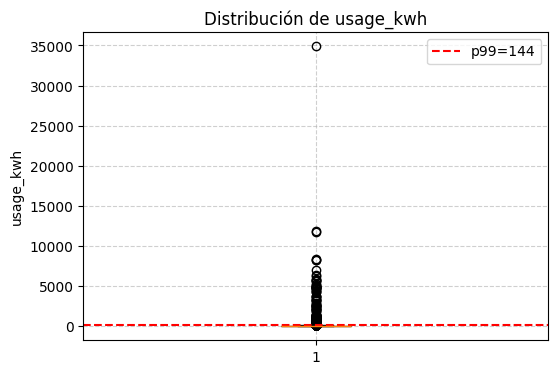


Describe (<= 157)
count    34896.000000
mean        27.371668
std         33.466695
min          0.000000
25%          3.200000
50%          4.570000
75%         51.160000
max        156.240000
Name: usage_kwh, dtype: float64
count    34377.000000
mean        18.756142
std         90.566039
min          0.000000
5%           0.000000
25%          2.300000
50%          5.000000
75%         23.220000
99%         75.044800
max       6145.920000
Name: lagging_current_reactive.power_kvarh, dtype: float64


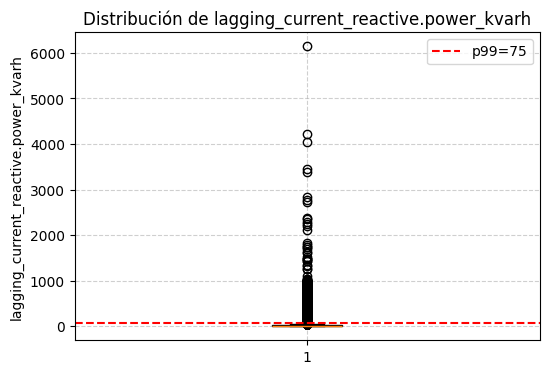

count    34394.000000
mean         2.618909
std         41.602429
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.020000
96%          0.050000
99%          0.060000
99.5%        2.911050
max       1364.040000
Name: co2(tco2), dtype: float64


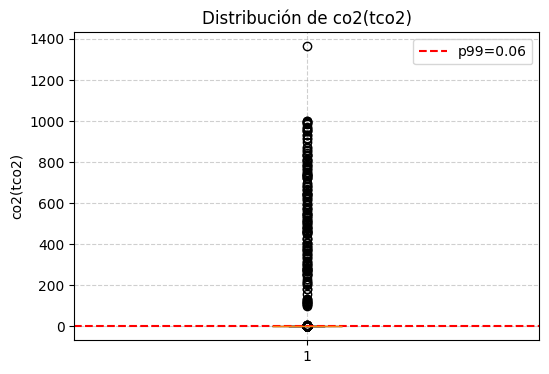


Filtrado: co2(tco2) <= 0.07
<class 'pandas.core.frame.DataFrame'>
Index: 34161 entries, 1 to 35734
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  12702 non-null  datetime64[ns]
 1   usage_kwh                             34161 non-null  float64       
 2   lagging_current_reactive.power_kvarh  33655 non-null  float64       
 3   leading_current_reactive_power_kvarh  33643 non-null  float64       
 4   co2(tco2)                             34161 non-null  float64       
 5   lagging_current_power_factor          33614 non-null  float64       
 6   leading_current_power_factor          33657 non-null  float64       
 7   nsm                                   33630 non-null  float64       
 8   weekstatus                            33808 non-null  object        
 9   day_of_week                           33850 non-

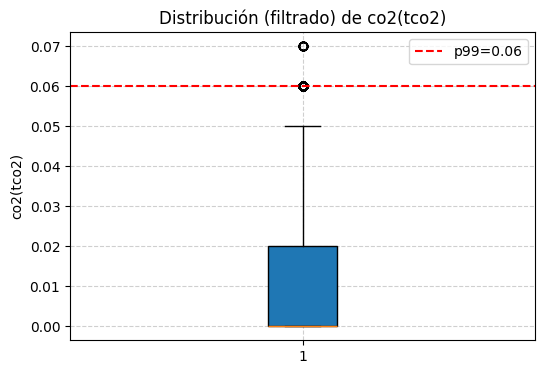

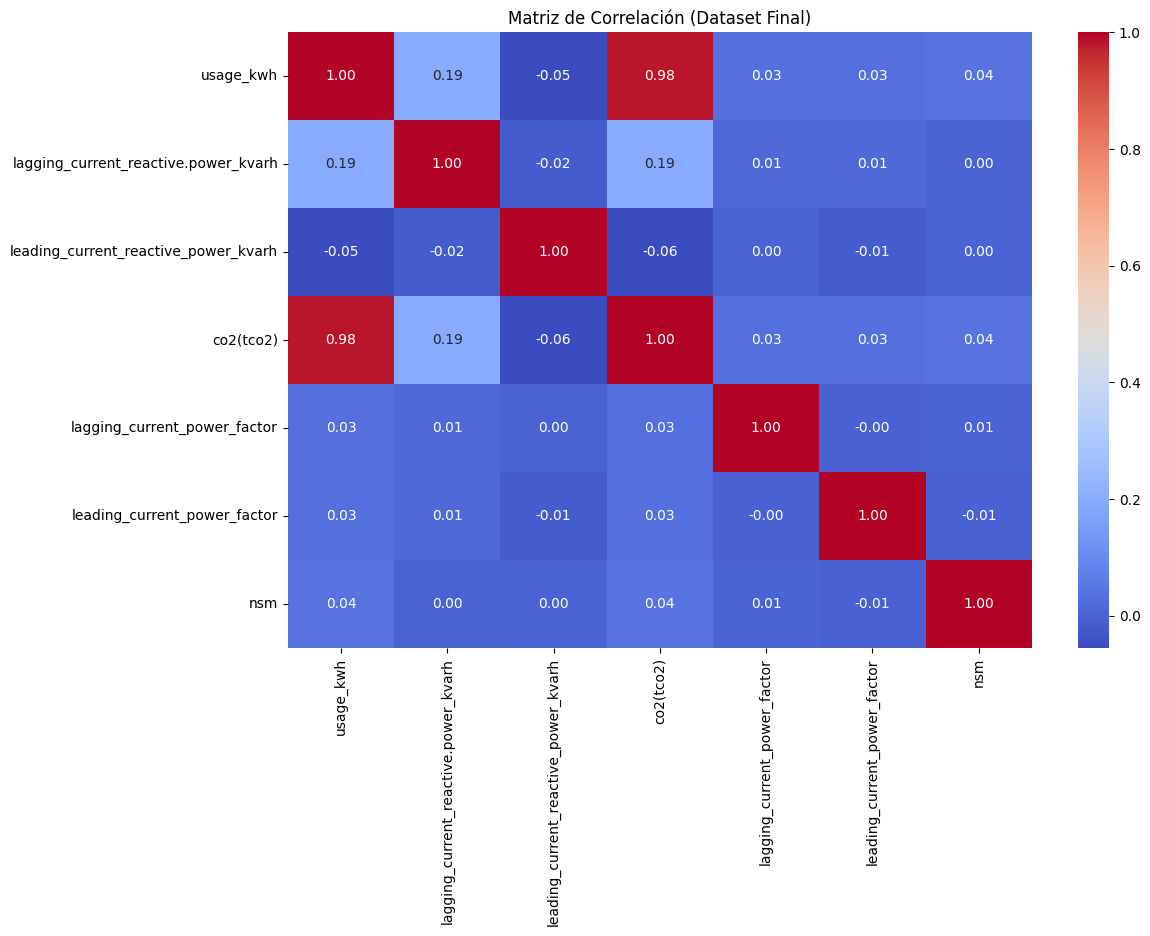


Conteo de NaN por columna:
date                                    21216
usage_kwh                                   0
lagging_current_reactive.power_kvarh        0
leading_current_reactive_power_kvarh        0
co2(tco2)                                   0
lagging_current_power_factor                0
leading_current_power_factor                0
nsm                                         0
weekstatus                                  0
day_of_week                                 0
load_type                                   0
dtype: int64

Muestra aleatoria (20 filas):
                     date  usage_kwh  lagging_current_reactive.power_kvarh  \
14649 2018-02-06 14:30:00       3.13                                  0.00   
29490 2018-04-11 04:45:00       2.95                                  5.00   
12435 2018-10-05 13:00:00       6.19                                  0.00   
32554 2018-06-12 02:45:00       3.38                                  2.74   
2566                  NaT       

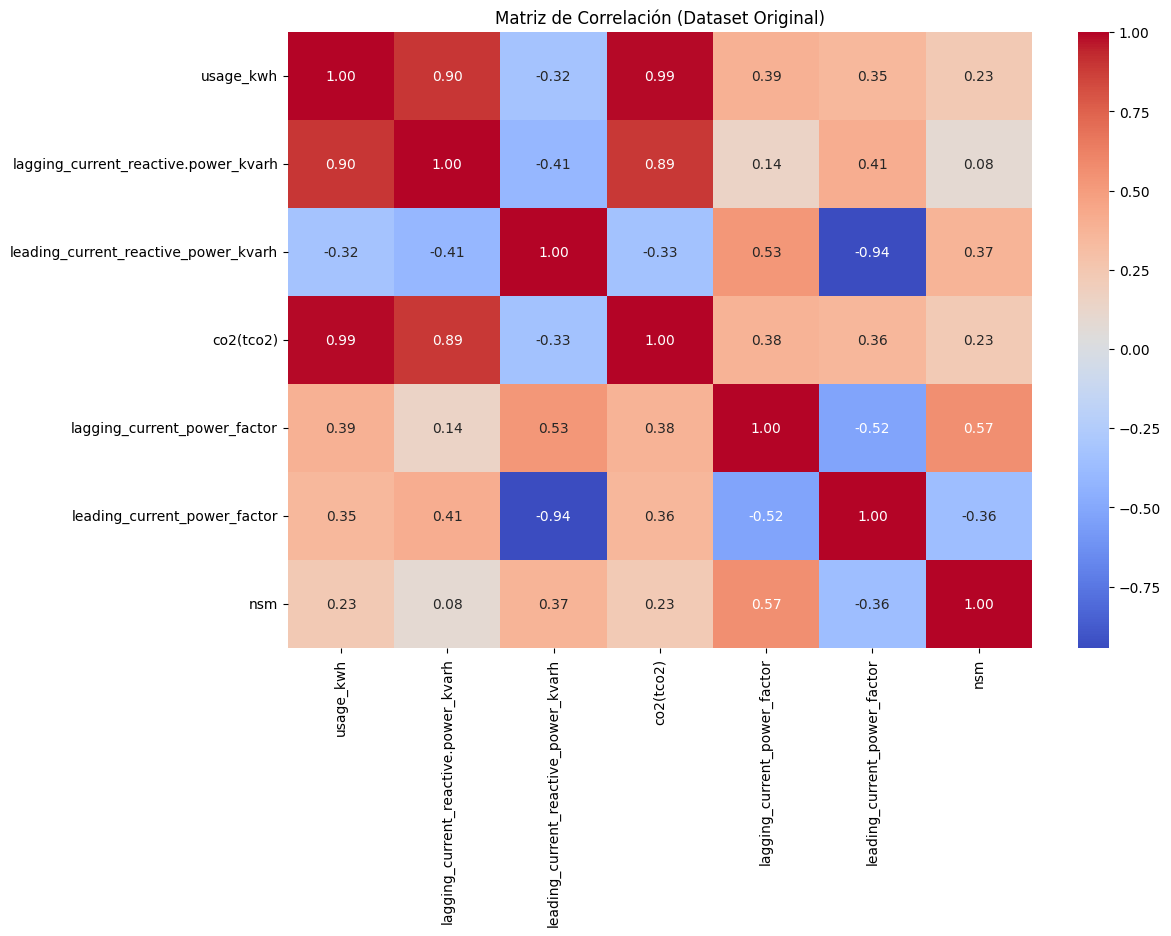

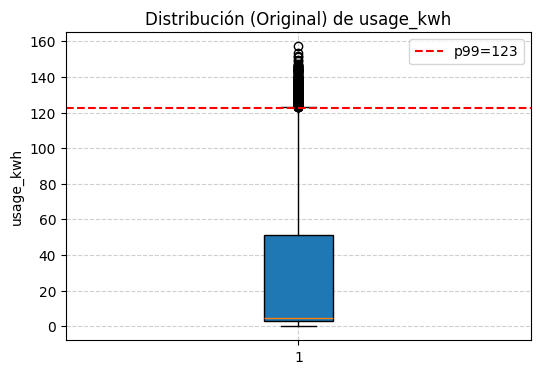


Comparación p99 de usage_kwh → Original: 122.708 | Modificado: 143.677

✅ Pipeline POO finalizado.


In [ ]:

# Rutas de ejemplo
path_modificado = "../../data/raw/steel_energy_modified.csv"
path_objetivo   = "../../data/raw/steel_energy_original.csv"  # pon None si no usarás el original

pipe = SteelEnergyPipeline(target_col=TARGET_COL)
resultados = pipe.run_for_paths(
    path_modificado=path_modificado,
    path_objetivo=path_objetivo
)

# Accesos rápidos
# resultados["df_clean"].head()
# resultados["df_final"].info()
